Based on following:

https://www.tensorflow.org/tutorials/load_data/images


https://www.tensorflow.org/tutorials/keras/basic_classification





In [26]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

tf.enable_eager_execution()
print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

# TensorFlow and tf.keras

from tensorflow import keras

from google.colab import drive



# This will prompt for authorization.
drive.mount('/content/drive')

1.14.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define Constants

In [0]:
# DEFINE CONSTANTS
data_root_path = "/content/drive/My Drive/Colab Notebooks/raw/raw/"
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_WIDTH = 1920 #384
IMAGE_HEIGHT = 520 #104

In [28]:
# IMPORT FILES AND LABELS
import pathlib
data_root = pathlib.Path(data_root_path)
print(data_root)

/content/drive/My Drive/Colab Notebooks/raw/raw


In [29]:
for item in data_root.iterdir():
  print(item)

/content/drive/My Drive/Colab Notebooks/raw/raw/links
/content/drive/My Drive/Colab Notebooks/raw/raw/rechts


In [30]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

413

In [31]:
all_image_paths[:10]

['/content/drive/My Drive/Colab Notebooks/raw/raw/rechts/20190828-094619.jpg',
 '/content/drive/My Drive/Colab Notebooks/raw/raw/rechts/20190828-095707.jpg',
 '/content/drive/My Drive/Colab Notebooks/raw/raw/links/20190828-100451.jpg',
 '/content/drive/My Drive/Colab Notebooks/raw/raw/rechts/20190828-095333.jpg',
 '/content/drive/My Drive/Colab Notebooks/raw/raw/links/20190828-100806.jpg',
 '/content/drive/My Drive/Colab Notebooks/raw/raw/links/20190828-094532.jpg',
 '/content/drive/My Drive/Colab Notebooks/raw/raw/rechts/20190828-095420.jpg',
 '/content/drive/My Drive/Colab Notebooks/raw/raw/links/20190828-100124.jpg',
 '/content/drive/My Drive/Colab Notebooks/raw/raw/links/20190828-100137.jpg',
 '/content/drive/My Drive/Colab Notebooks/raw/raw/links/20190828-100923.jpg']


# Inspect the images. Now let's have a quick look at a couple of the images, so you know what you're dealing with:

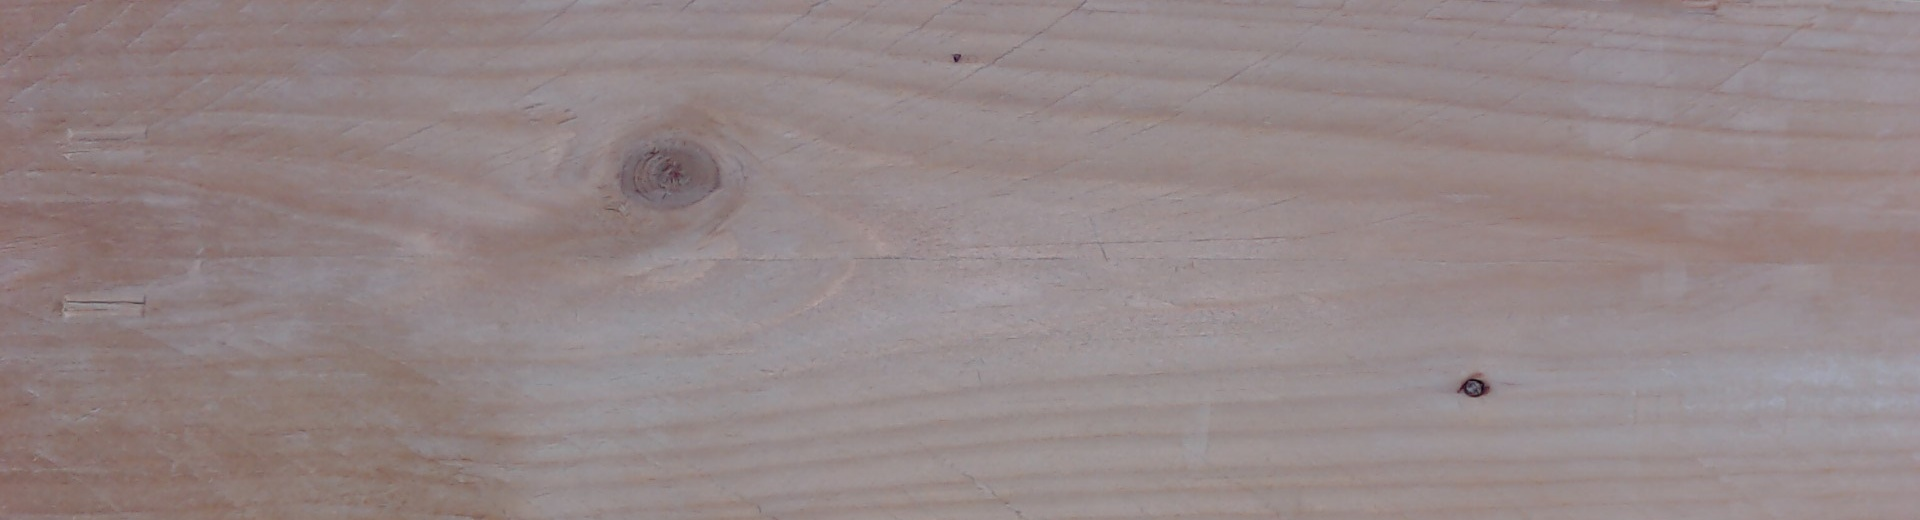

/content/drive/My Drive/Colab Notebooks/raw/raw/links/20190828-094612.jpg



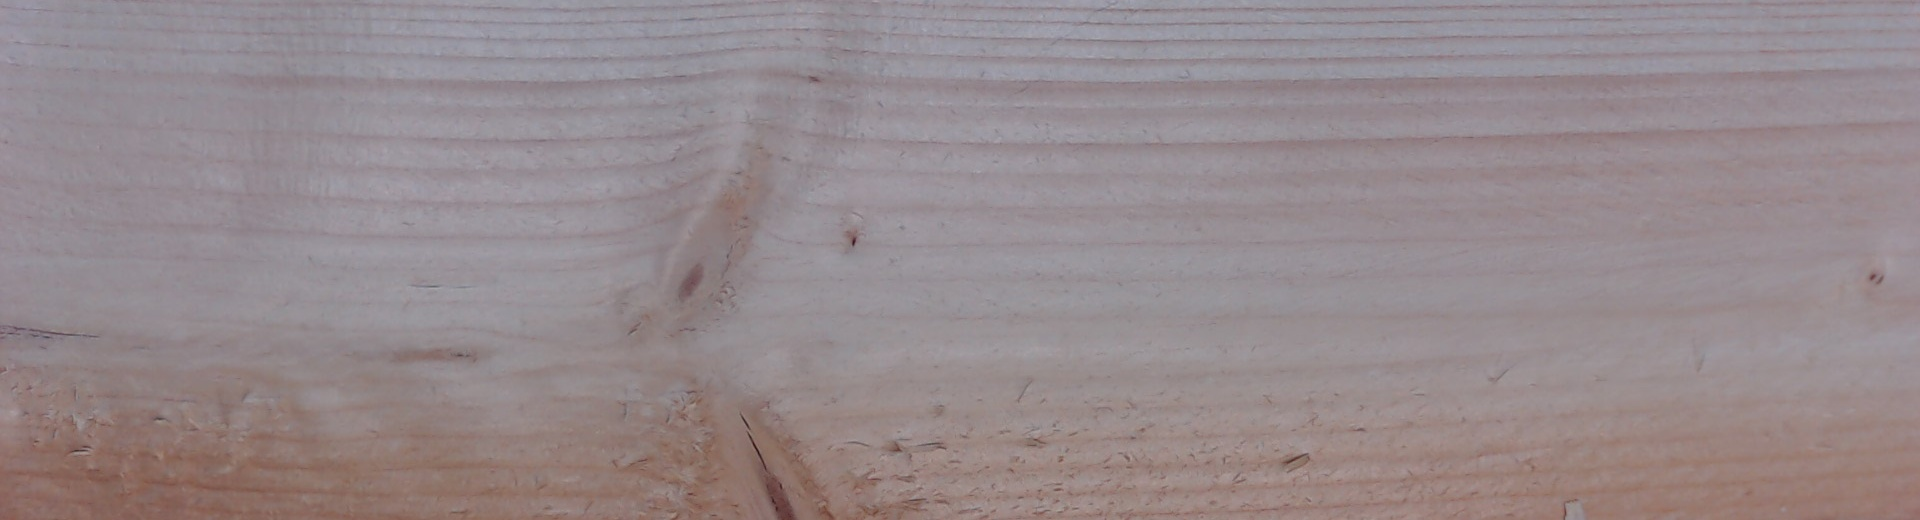

/content/drive/My Drive/Colab Notebooks/raw/raw/rechts/20190828-100349.jpg



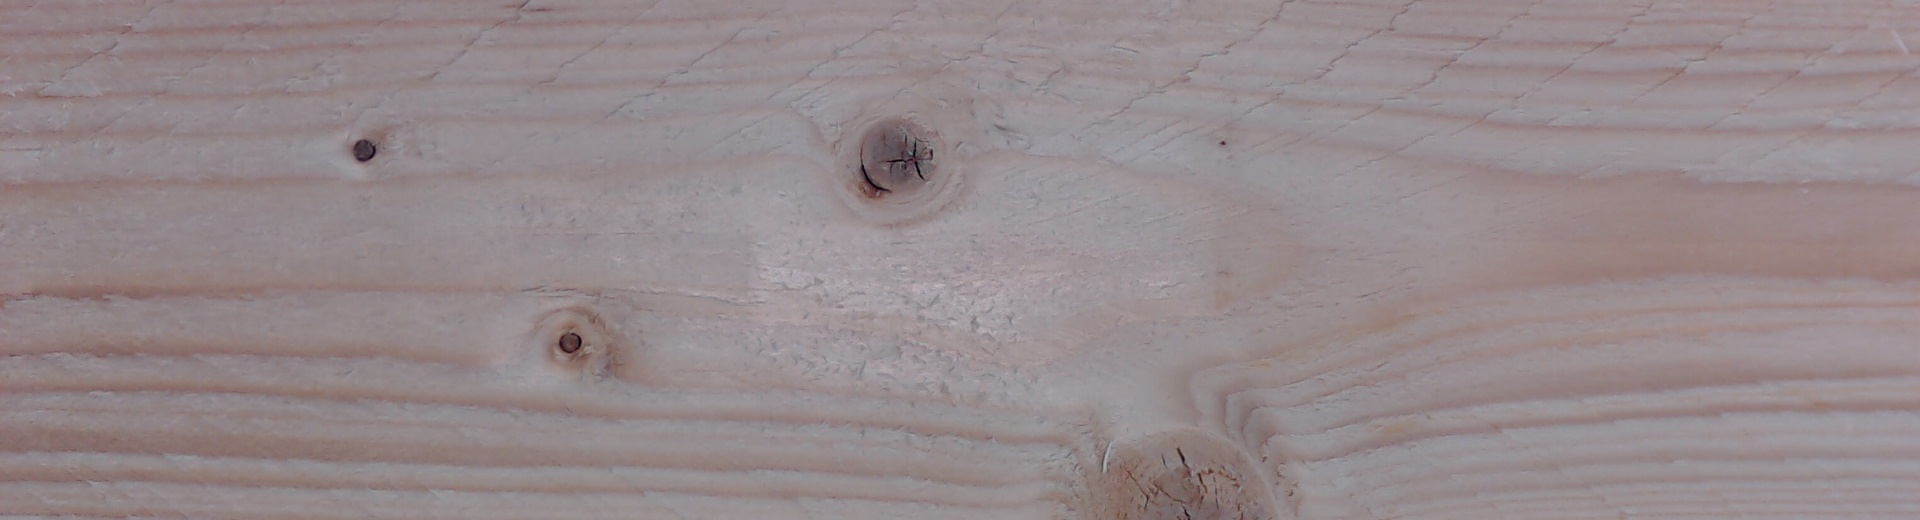

/content/drive/My Drive/Colab Notebooks/raw/raw/links/20190828-095614.jpg



In [32]:
import IPython.display as display
import os
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print(image_path)
  print()


# Determine the label for each image
## List the available labels:

In [33]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['links', 'rechts']

Assign an index to each label:

In [34]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'links': 0, 'rechts': 1}

Create a list of every file, and its label index

In [35]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [1, 1, 0, 1, 0, 0, 1, 0, 0, 0]


# Load and format the images
## TensorFlow includes all the tools you need to load and process images:

In [0]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  #image = tf.image.resize(image, [104, 384])
  image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
  image /= 255.0  # normalize to [0,1] range

  return image

In [0]:
def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

Build a tf.data.Dataset
A dataset of images
The easiest way to build a tf.data.Dataset is using the from_tensor_slices method.

Slicing the array of strings results in a dataset of strings:

In [0]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

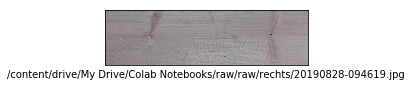

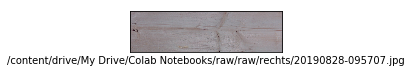

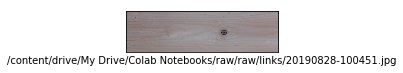

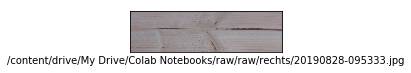

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(all_image_paths[n])
  plt.show()

In [0]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

rechts
rechts
links
rechts
links
links
rechts
links
links
links


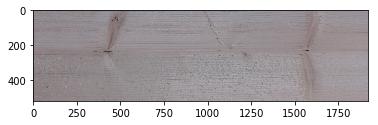

In [41]:
for label in label_ds.take(10):
  print(label_names[label.numpy()])
  
for image in image_ds.take(1):
  plt.imshow(image)
  plt.show()
   

In [0]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [43]:
print(image_label_ds)

<DatasetV1Adapter shapes: ((520, 1920, 3), ()), types: (tf.float32, tf.int64)>


In [0]:
DATASET_SIZE = image_count
train_size = int(0.85 * DATASET_SIZE)
test_size = int(DATASET_SIZE - train_size)


train_dataset = image_label_ds.take(train_size)
test_dataset = image_label_ds.skip(train_size)
test_dataset = image_label_ds.take(test_size)

In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [47]:
model.fit(train_dataset.shuffle(5).batch(1), epochs=1)

351/351 [==============================] - 536s 2s/step - loss: 8.7715 - acc: 0.4558


In [48]:
test_loss, test_acc = model.evaluate(test_dataset.batch(1))
print('Test accuracy:', test_acc)

62/62 [==============================] - 18s 298ms/step - loss: 10.1388 - acc: 0.3710
Test accuracy: 0.37096775


<DatasetV1Adapter shapes: (520, 1920, 3), types: tf.float32>
<DatasetV1Adapter shapes: (), types: tf.int64>
<DatasetV1Adapter shapes: ((520, 1920, 3), ()), types: (tf.float32, tf.int64)>


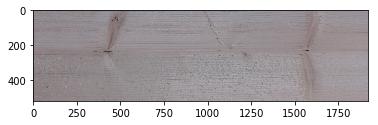

In [49]:
print(image_ds)
print(label_ds)
print(image_label_ds)

for image_label_pair in train_dataset.take(1):
  image = image_label_pair[0]
  plt.imshow(image)
  plt.show()